# Network Anomaly Detection

## Project Topic

The goal of this project is to build an accurate model for detecting and categorizing cyber attacks using the features commonly found in network logs (specifically `tcpdump`).

I will develop two unsupervised models and compare their performance and characteristics against a proven supervised approach for this task.

- Random Forest (Supervised)
- KMeans Clustering (Unsupervised)
- Isolation Forest (Unsupervised)

My motivation for exploring these approaches is to determine the viability of a near real-time network attack categorization tool that can operate on a stream of logs. I want to investigate if the advantages of unsupervised models on dynamic datasets could outweigh the proven accuracy of supervised models.

## Setup

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

RANDOM_STATE = 418

%matplotlib inline
%load_ext jupyter_black

## Data

This project uses a public dataset that can be found here: https://research.unsw.edu.au/projects/unsw-nb15-dataset

I'm using this slightly modified and smaller sample of the full dataset: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15

The dataset was created by the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS) and includes a mix of real modern normal activities and synthetic contemporary attack behaviours.

> Free use of the UNSW-NB15 dataset for academic research purposes is hereby granted in perpetuity. To whom intend the use of the UNSW-NB15 dataset have to cite these five papers.
> Moustafa, Nour, et al. "An Ensemble Intrusion Detection Technique based on proposed Statistical Flow Features for Protecting Network Traffic of Internet of Things." IEEE Internet of Things Journal (2018).
Koroniotis, Nickolaos, Moustafa, Nour, et al. "Towards Developing Network Forensic Mechanism for Botnet Activities in the IoT Based on Machine Learning Techniques." International Conference on Mobile Networks and Management. Springer, Cham, 2017.
Moustafa, Nour, et al. "Generalized Outlier Gaussian Mixture technique based on Automated Association Features for Simulating and Detecting Web Application Attacks." IEEE Transactions on Sustainable Computing (2018).
Keshk, Marwa, Moustafa, Nour, et al. "Privacy preservation intrusion detection technique for SCADA systems." Military Communications and Information Systems Conference (MilCIS), 2017. IEEE, 2017.
Moustafa, Nour, et al. "A New Threat Intelligence Scheme for Safeguarding Industry 4.0 Systems." IEEE Access (2018).
Moustafa, Nour, et al. "Anomaly Detection System Using Beta Mixture Models and Outlier Detection." Progress in Computing, Analytics and Networking. Springer, Singapore, 2018. 125-135.
Moustafa, Nour, et al. "Flow Aggregator Module for Analysing Network Traffic." Progress in Computing, Analytics and Networking. Springer, Singapore, 2018. 19-29.
Moustafa, Nour, et al. "A Network Forensic Scheme Using Correntropy-Variation for Attack Detection." IFIP International Conference on Digital Forensics. Springer, Cham, 2018.

In [2]:
train_data = pd.read_csv("./data/UNSW_NB15_training-set.csv")
test_data = pd.read_csv("./data/UNSW_NB15_testing-set.csv")

## Exploratory Data Analysis

This dataset is large, and has a huge number of features. I suspect we will need to investigate some feature reduction techniques.

I also check for missing values in the data, and fortunately it seems we have a complete data set. We should watch out for outliers or impossible values, but for the most part this data seems clean and reliable.

In [4]:
print(f"Number of entries: {len(train_data)}")
print(f"Number of features: {train_data.shape[1]}")

missing_values = train_data.isnull().sum()
print(f"Missing values: {missing_values.sum()}")

Number of entries: 175341
Number of features: 45
Missing values: 0


### Data Transformation

This data will need transformed for all three of my models. I'll use this section to develop a transformation pipeline for each model.

#### Random Forest Data Transformation

#### KMeans Clustering Data Transformation

#### Isolation Forest Data Transformation

### Data Distribution Analysis

The models we will develop have a binary catigorization problem (`label` 0=normal, 1=attack) and a multi-class categorization problem (`attack_cat`). Let's check the distribution of these two features.

In [5]:
label_counts = train_data["label"].value_counts()
label_percentages = 100 * train_data["label"].value_counts(normalize=True)

print(
    pd.DataFrame({"Count": label_counts, "Percentage (%)": label_percentages.round(2)})
)

        Count  Percentage (%)
label                        
1      119341           68.06
0       56000           31.94


In [6]:
attack_cat_counts = train_data["attack_cat"].value_counts()
attack_cat_percentages = 100 * train_data["attack_cat"].value_counts(normalize=True)

print(
    pd.DataFrame(
        {"Count": attack_cat_counts, "Percentage (%)": attack_cat_percentages.round(2)}
    )
)

                Count  Percentage (%)
attack_cat                           
Normal          56000           31.94
Generic         40000           22.81
Exploits        33393           19.04
Fuzzers         18184           10.37
DoS             12264            6.99
Reconnaissance  10491            5.98
Analysis         2000            1.14
Backdoor         1746            1.00
Shellcode        1133            0.65
Worms             130            0.07


### Feature Analysis

This dataset has a lot of features, so it will take some work to understand how features interact and what features are important.

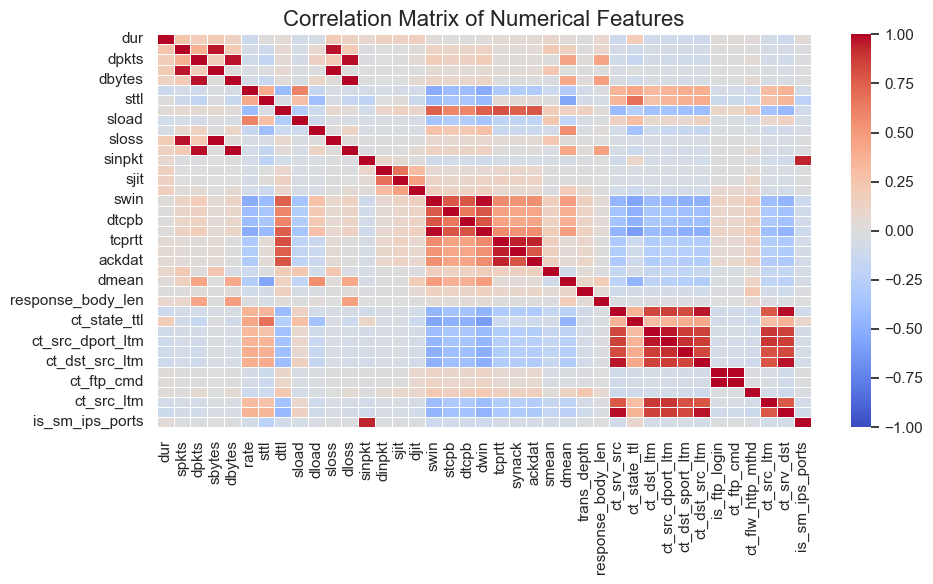

In [9]:
numeric_columns = train_data.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
if "label" in numeric_columns:
    numeric_columns.remove("label")
if "id" in numeric_columns:
    numeric_columns.remove("id")

correlation_matrix = train_data[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

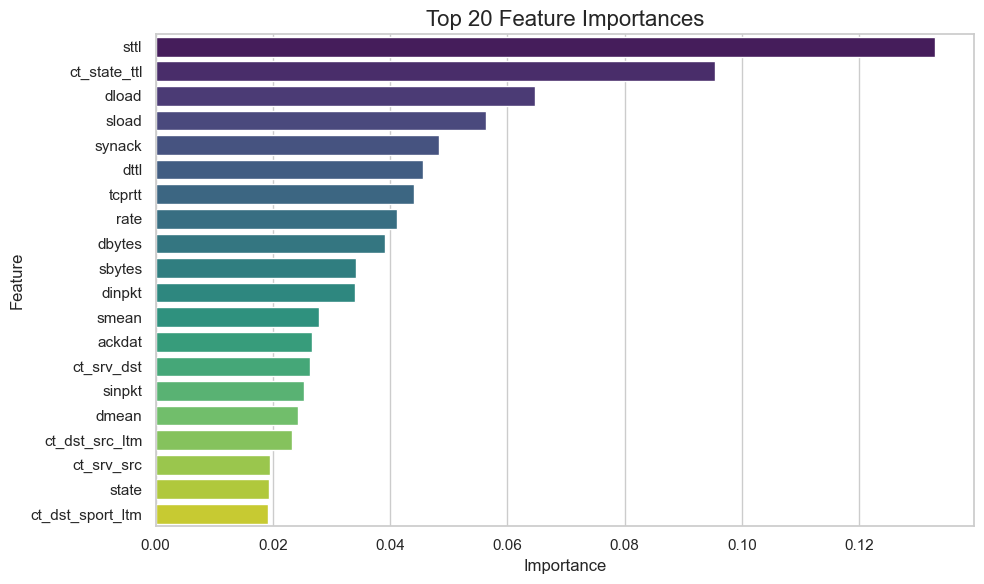

In [11]:
categorical_columns = ["proto", "service", "state", "attack_cat"]
X_encoded = train_data.drop(["label", "attack_cat", "id"], axis=1).copy()

for column in categorical_columns:
    if column in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column])

y = train_data["label"]
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_encoded, y)

feature_importances = pd.DataFrame(
    {"Feature": X_encoded.columns, "Importance": rf.feature_importances_}
).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", y="Feature", data=feature_importances.head(20), palette="viridis"
)
plt.title("Top 20 Feature Importances", fontsize=16)
plt.tight_layout()
plt.show()